In [1]:
import torch 
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from dataset import ImitationLearningDataset
from model import Network, BranchedNetwork
from config import get_cfg_defaults
import matplotlib.pyplot as plt 
import cv2
import h5py
import glob
import albumentations as A 
from albumentations.pytorch import ToTensorV2

In [2]:
cfg = get_cfg_defaults()
dataset = ImitationLearningDataset(cfg, "train")

In [3]:
print(len(dataset))

657600


In [4]:
device = torch.device("cpu")

In [5]:
checkpoint = "/home/johann/dev/conditional-imitation-learning-pytorch/exps/2023-03-26/checkpoints/best.pth"
model = torch.load(checkpoint) 
model.to(device)

BranchedNetwork(
  (perception): PerceptionModule(
    (conv): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (drop): Dropout(p=0.2, inplace=False)
      )
      (1): ConvBlock(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (drop): Dropout(p=0.2, inplace=False)
      )
      (2): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (drop): Dropout(p=0.2, inplace=False)
      )
      (3): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [12]:
val_dataset = ImitationLearningDataset(cfg, "val")
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=4, shuffle=True)

In [24]:
loss_fn = torch.nn.MSELoss(reduction="sum")
loss_weights = {
    'steer': 0.5, 
    'acc': 0.45, 
    'brake': 0.05,
}

torch.Size([1, 88, 200, 3])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]])
target: tensor([[-0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.0000,
          0.0000, -0.0155,  0.5000,  0.0000]], dtype=torch.float64)
pred: tensor([[ 0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0382,  0.0504,  0.0068]])
steer_loss: 0.0005155605812010057
accel_loss: 0.20218251679111376
brake loss: 4.5958037865092595e-05
total loss: 0.09124221074849495


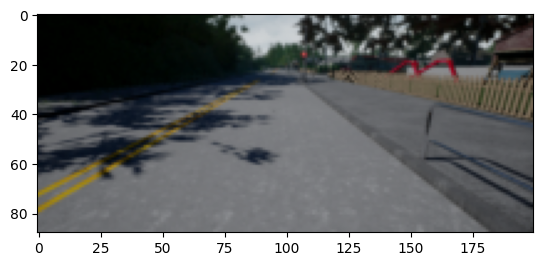

In [27]:
for idx, (org_img, img, speed, mask, target) in enumerate(val_dataloader): 
    print(org_img.shape)
    org_img = org_img.squeeze(0).numpy() 
    org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
    plt.imshow(org_img) 
    img = img.to(device)
    speed = speed.to(device)
    mask = mask.to(device)
    target = target.to(device)

    with torch.no_grad(): 
        out = model(img, speed)

    target = target * mask
    out = out * mask
    print(mask) 
    print(f"target: {target}")
    print(f"pred: {out}") 
    steer_loss = loss_fn(out.reshape((-1, 4, 3))[:, :, 0], target.reshape((-1, 4, 3))[:, :, 0])
    acc_loss = loss_fn(out.reshape((-1, 4, 3))[:, :, 1], target.reshape((-1, 4, 3))[:, :, 1])
    brake_loss = loss_fn(out.reshape((-1, 4, 3))[:, :, 2], target.reshape((-1, 4, 3))[:, :, 2])
    loss = (
        loss_weights['steer'] * steer_loss +
        loss_weights['acc'] * acc_loss +
        loss_weights['brake'] * brake_loss
    )
    print(f"steer_loss: {steer_loss}") 
    print(f"accel_loss: {acc_loss}")
    print(f"brake loss: {brake_loss}")
    print(f"total loss: {loss}")
    break  

In [33]:
opts = ["MODEL.BRANCHED", False]
cfg.merge_from_list(opts)

In [34]:
val_dataset = ImitationLearningDataset(cfg, "val")
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=4, shuffle=True)

In [35]:
model = Network(cfg)
model.to(device)

Network(
  (perception): PerceptionModule(
    (conv): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (drop): Dropout(p=0.2, inplace=False)
      )
      (1): ConvBlock(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (drop): Dropout(p=0.2, inplace=False)
      )
      (2): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (drop): Dropout(p=0.2, inplace=False)
      )
      (3): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [36]:
loss_fn = torch.nn.MSELoss(reduction="mean")
loss_weights = {
    'steer': 0.5, 
    'acc': 0.45, 
    'brake': 0.05,
}

pred steer: tensor([0.0715])
pred acc: tensor([0.0571])


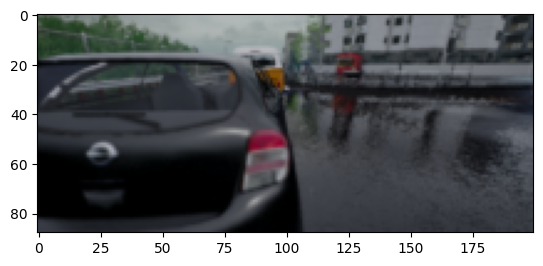

In [39]:
for idx, (org_img, img, speed, cmd, target) in enumerate(val_dataloader): 
    org_img = org_img.squeeze(0).numpy() 
    org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
    plt.imshow(org_img) 
    img = img.to(device)
    speed = speed.to(device)
    cmd = cmd.to(device)
    target = target.to(device)

    with torch.no_grad(): 
        out = model(img, speed, cmd)

    gt_steer, gt_acc, gt_brake = target[:, 0], target[:, 1], target[:, 2]
    pred_steer, pred_acc, pred_brake = out[:,0], out[:,1], out[:,2] 
    print(f"pred steer: {pred_steer}")
    print(f"pred acc: {pred_acc}")
    print(f"pred brake: {pred_brake}")
    
    print(f"target steer: {gt_steer}")
    print(f"target acc: {gt_acc}")
    print(f"target brake: {gt_brake}")

    steer_loss = loss_fn(pred_steer, gt_steer)
    acc_loss = loss_fn(pred_acc, gt_acc)
    brake_loss = loss_fn(pred_brake, gt_brake)

    loss = (
        loss_weights['steer'] * steer_loss + 
        loss_weights['acc'] * acc_loss + 
        loss_weights['brake'] * brake_loss
    )

    print(f"steer loss: {steer_loss}")
    print(f"acc loss: {acc_loss}")
    print(f"brake loss: {brake_loss}")
    print(f"loss: {loss}")
    
    break